# Calculating Elder Impulse for long view

In [1]:
# IMPORTING PACKAGES

import pandas as pd
import requests
from datetime import datetime, timedelta
import talib
import matplotlib.pyplot as plt
import time

/var/folders/sk/ckljlph97j1grnldzlf4khtc0000gn/T/ipykernel_32143/522971493.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Getting historical data from binance API

In [2]:
#The variable days_back represents the number of days in the past from which I intend to retrieve the data.
#The variable symbol is a coin pair. For example if you want bitcoin historical data, the symbol to use is BTCUSDT. 

API_URL = 'https://api.binance.com/api/v3/klines' # Binance API endpoint for candlestick data



def get_historical_data(symbol, days_back, interval):
    # Calculate the start time in milliseconds
    start_time = int((datetime.now() - timedelta(days=days_back)).timestamp() * 1000)

    # Calculate the current time in milliseconds
    end_time = int(datetime.now().timestamp() * 1000)

    # Make an API request to retrieve historical data
    response = requests.get(API_URL, params={
        'symbol': symbol,
        'interval': interval,
        'startTime': start_time,
        'endTime': end_time,
        'limit': 1000  # Maximum number of data points per request
    })

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # API request was successful
        hist_json = response.json()

        # Making a df from response
        # Extract only the relevant elements for each row
        df = pd.DataFrame(hist_json, columns=[
            'Time', 'Open Price', 'High Price', 'Low Price',
            'Close Price', 'Volume', 'Kline Close Time', 'Quote Asset Volume',
            'Number of Trades', 'Taker Buy Base Asset Volume',
            'Taker Buy Quote Asset Volume', 'Unused Field'
        ])

        # Select only the relevant columns (Open Time, Open Price, High Price, Low Price, Close Price, Volume)
        df = df[['Time', 'Open Price', 'High Price', 'Low Price', 'Close Price', 'Volume']]
        df['dateTime'] = pd.to_datetime(df['Time'], unit='ms')
        print("Retrived data for: " + symbol)

        return df
    else:
        # API request was not successful, print an error message
        print(f"Error: API request failed with status code {response.status_code}")
        return None


In [3]:
def transform_hist_data(df_name):
    df_name['Open Price'] = pd.to_numeric(df_name['Open Price'], errors='coerce').astype(float)
    df_name['High Price'] = pd.to_numeric(df_name['High Price'], errors='coerce').astype(float)
    df_name['Low Price'] = pd.to_numeric(df_name['Low Price'], errors='coerce').astype(float)
    df_name['Close Price'] = pd.to_numeric(df_name['Close Price'], errors='coerce').astype(float)
    df_name['Volume'] = pd.to_numeric(df_name['Volume'], errors='coerce').astype(float)
    return df_name


## Creating a table for calculating elder impulse

Elder Impulse
https://school.stockcharts.com/doku.php?id=chart_analysis:elder_impulse_system
MACD-histogram
https://www.investopedia.com/ask/answers/122414/what-moving-average-convergence-divergence-macd-formula-and-how-it-calculated.asp

In [4]:
df_long = get_historical_data('BTCUSDT', 360, '1w')


Retrived data for: BTCUSDT


In [5]:
df_long.head(10)

,Time,Open Price,High Price,Low Price,Close Price,Volume,dateTime
0,1678060800000,22430.24000000,22602.19000000,19549.09000000,21997.11000000,2718623.72856000,2023-03-06
1,1678665600000,21998.05000000,28390.10000000,21813.88000000,27972.87000000,3775888.94983000,2023-03-13
2,1679270400000,27972.87000000,28868.05000000,26601.80000000,27968.05000000,1437828.84706000,2023-03-20
3,1679875200000,27968.05000000,29184.68000000,26508.14000000,28171.87000000,500795.73087000,2023-03-27
4,1680480000000,28171.87000000,28775.00000000,27200.24000000,28323.76000000,306532.39014000,2023-04-03
5,1681084800000,28323.76000000,31000.00000000,28170.00000000,30304.65000000,377573.74044000,2023-04-10
6,1681689600000,30304.66000000,30485.00000000,27125.00000000,27590.60000000,430421.84646000,2023-04-17
7,1682294400000,27590.59000000,30036.00000000,26942.82000000,29233.21000000,444613.47701000,2023-04-24
8,1682899200000,29233.20000000,29820.00000000,27666.95000000,28430.10000000,360117.97447000,2023-05-01
9,1683504000000,28430.09000000,28631.01000000,25811.46000000,26917.62000000,338765.74243000,2023-05-08


In [6]:
df_long = transform_hist_data(df_long)

In [7]:
#Function for calculating EMA-s
def calculate_emas(df_name):
    df_name['13EMA'] = df_name['Close Price'].ewm(span=13, adjust=False).mean()
    df_name['12EMA'] = df_name['Close Price'].ewm(span=12, adjust=False).mean()
    df_name['26EMA'] = df_name['Close Price'].ewm(span=26, adjust=False).mean()
    return df_name
    

In [8]:
df_long = calculate_emas(df_long)

In [9]:
def calculate_macd(df_name):
    # Calculate MACD Line (12EMA - 26EMA)
    df_name['MACD'] = df_name['12EMA'] - df_name['26EMA']

    # Calculate Signal Line (9-period EMA of MACD)
    df_name['Signal'] = df_name['MACD'].ewm(span=9, adjust=False).mean()

    # Calculate MACD Histogram
    df_name['Histogram'] = df_name['MACD'] - df_name['Signal']
    return df_name
    

In [10]:
df_long = calculate_macd(df_long)

In [11]:
df_long.tail()

,Time,Open Price,High Price,Low Price,Close Price,Volume,dateTime,13EMA,12EMA,26EMA,MACD,Signal,Histogram
47,1706486400000,42031.05,43882.36,41804.88,42582.88,203036.61925,2024-01-29,40174.154188,40480.278326,36703.675933,3776.602393,3617.655321,158.947071
48,1707091200000,42582.88,48592.66,42258.10,48299.99,262240.48357,2024-02-05,41334.987875,41683.310891,37562.662160,4120.648731,3718.254003,402.394728
49,1707696000000,48300.00,52816.62,47710.01,52137.67,310862.30170,2024-02-12,42878.228179,43291.673831,38642.292371,4649.381460,3904.479495,744.901966
50,1708300800000,52137.68,52985.00,50521.00,51728.85,223366.16186,2024-02-19,44142.602725,44589.700934,39611.667010,4978.033924,4119.190380,858.843543
51,1708905600000,51728.85,51796.50,50901.44,51092.12,11169.49698,2024-02-26,45135.390907,45590.073098,40462.070935,5128.002163,4320.952737,807.049426


## Calculating elder impulse

Kalkuleerin elder impulse iga rea kohta tabelis

In [23]:
def calculate_elder(df_name):

    for i in range(1, len(df_name)):
        ema_comparison = 0
        macd_comparison = 0
        first_row_ema = df_name.iloc[i-1]['13EMA']
        second_row_ema = df_name.iloc[i]['13EMA']
        if second_row_ema > first_row_ema:
            ema_comparison = 1
        elif second_row_ema < first_row_ema:
            ema_comparison = -1
        first_row_macd = df_name.iloc[i-1]['Histogram']
        second_row_macd = df_name.iloc[i]['Histogram']
        if second_row_macd > first_row_macd:
            macd_comparison = 1
        elif second_row_macd < first_row_macd:
            macd_comparison = -1
        if ema_comparison == 1 and macd_comparison == 1:
              df_name.at[i, 'elder_impulse'] = 1
        elif ema_comparison == -1 and macd_comparison == -1:
            df_name.at[i, 'elder_impulse'] = -1
        else:
            df_name.at[i, 'elder_impulse'] = 0
    return df_name

In [13]:
df_long = calculate_elder(df_long)


In [14]:
df_long.tail(10)

,Time,Open Price,High Price,Low Price,Close Price,Volume,dateTime,13EMA,12EMA,26EMA,MACD,Signal,Histogram,elder_impulse
42,1703462400000,42991.50,43802.32,41300.00,42283.58,228462.70228,2023-12-25,37691.173846,38093.671265,34059.355675,4034.315590,2960.471313,1073.844276,0.0
43,1704067200000,42283.58,45879.63,40750.00,43929.02,310487.48622,2024-01-01,38582.294726,38991.417224,34790.441921,4200.975303,3208.572111,992.403192,0.0
44,1704672000000,43929.01,48969.48,41500.00,41732.35,470798.80434,2024-01-08,39032.302622,39413.099190,35304.657335,4108.441855,3388.546060,719.895795,0.0
45,1705276800000,41732.35,43578.01,40280.00,41580.33,238486.27274,2024-01-15,39396.306533,39746.519314,35769.521976,3976.997338,3506.236316,470.761022,0.0
46,1705881600000,41580.32,42842.68,38555.00,42031.06,274603.16207,2024-01-22,39772.699885,40097.987112,36233.339608,3864.647504,3577.918553,286.728951,0.0
47,1706486400000,42031.05,43882.36,41804.88,42582.88,203036.61925,2024-01-29,40174.154188,40480.278326,36703.675933,3776.602393,3617.655321,158.947071,0.0
48,1707091200000,42582.88,48592.66,42258.10,48299.99,262240.48357,2024-02-05,41334.987875,41683.310891,37562.662160,4120.648731,3718.254003,402.394728,1.0
49,1707696000000,48300.00,52816.62,47710.01,52137.67,310862.30170,2024-02-12,42878.228179,43291.673831,38642.292371,4649.381460,3904.479495,744.901966,1.0
50,1708300800000,52137.68,52985.00,50521.00,51728.85,223366.16186,2024-02-19,44142.602725,44589.700934,39611.667010,4978.033924,4119.190380,858.843543,1.0
51,1708905600000,51728.85,51796.50,50901.44,51092.12,11169.49698,2024-02-26,45135.390907,45590.073098,40462.070935,5128.002163,4320.952737,807.049426,0.0


if elder_impulse is 1, it means you can go long; 
if it is -1 , you can go short;
if it is 0 you can do both. 
It is best to go long if impulse is 1 or 0 after -1. (This should be considered good metricks for stock screening)

# Creating Medium view and ATR channels

In [15]:
df_medium = get_historical_data('BTCUSDT', 30, '1d')

Retrived data for: BTCUSDT


In [16]:
df_medium.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Time         30 non-null     int64         
 1   Open Price   30 non-null     object        
 2   High Price   30 non-null     object        
 3   Low Price    30 non-null     object        
 4   Close Price  30 non-null     object        
 5   Volume       30 non-null     object        
 6   dateTime     30 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 1.8+ KB


In [17]:
df_medium = transform_hist_data(df_medium)

In [18]:
df_medium.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Time         30 non-null     int64         
 1   Open Price   30 non-null     float64       
 2   High Price   30 non-null     float64       
 3   Low Price    30 non-null     float64       
 4   Close Price  30 non-null     float64       
 5   Volume       30 non-null     float64       
 6   dateTime     30 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 1.8 KB


In [19]:
df_medium['ATR21'] = talib.ATR(df_medium['High Price'], df_medium['Low Price'], df_medium['Close Price'], timeperiod=21)
df_medium['ATR14'] = talib.ATR(df_medium['High Price'], df_medium['Low Price'], df_medium['Close Price'], timeperiod=14)

In [20]:
df_medium.tail()


,Time,Open Price,High Price,Low Price,Close Price,Volume,dateTime,ATR21,ATR14
25,1708560000000,51849.38,52065.78,50940.78,51288.42,35309.44574,2024-02-22,1480.347673,1485.336518
26,1708646400000,51288.42,51548.54,50521.00,50744.15,30545.79544,2024-02-23,1458.785403,1452.636767
27,1708732800000,50744.15,51698.00,50585.00,51568.22,16560.42110,2024-02-24,1442.319432,1428.376998
28,1708819200000,51568.21,51958.55,51279.80,51728.85,18721.63159,2024-02-25,1405.958982,1374.832212
29,1708905600000,51728.85,51796.50,50901.44,51112.59,11110.04444,2024-02-26,1381.630459,1340.562768


In [21]:
df_medium['13EMA'] = df_medium['Close Price'].ewm(span=13, adjust=False).mean()

I will choose ATR 21. Now I will create ATR +1, ATR +2, ATR -1 and -2. These are channels. Then we can compare price against these channels to find entry, stop loss and exit.

In [22]:
# Calculate 21-period EMA
df_medium['21EMA'] = df_medium['Close Price'].ewm(span=21, adjust=False).mean()
df_medium.tail()

,Time,Open Price,High Price,Low Price,Close Price,Volume,dateTime,ATR21,ATR14,13EMA,21EMA
25,1708560000000,51849.38,52065.78,50940.78,51288.42,35309.44574,2024-02-22,1480.347673,1485.336518,50426.108789,48992.594060
26,1708646400000,51288.42,51548.54,50521.00,50744.15,30545.79544,2024-02-23,1458.785403,1452.636767,50471.543248,49151.826418
27,1708732800000,50744.15,51698.00,50585.00,51568.22,16560.42110,2024-02-24,1442.319432,1428.376998,50628.211355,49371.498562
28,1708819200000,51568.21,51958.55,51279.80,51728.85,18721.63159,2024-02-25,1405.958982,1374.832212,50785.445447,49585.803238
29,1708905600000,51728.85,51796.50,50901.44,51112.59,11110.04444,2024-02-26,1381.630459,1340.562768,50832.180383,49724.602034


In [23]:
df_medium['ATR+1'] = df_medium['21EMA'] + df_medium['ATR21'] 

In [24]:
df_medium.tail()

,Time,Open Price,High Price,Low Price,Close Price,Volume,dateTime,ATR21,ATR14,13EMA,21EMA,ATR+1
25,1708560000000,51849.38,52065.78,50940.78,51288.42,35309.44574,2024-02-22,1480.347673,1485.336518,50426.108789,48992.594060,50472.941733
26,1708646400000,51288.42,51548.54,50521.00,50744.15,30545.79544,2024-02-23,1458.785403,1452.636767,50471.543248,49151.826418,50610.611821
27,1708732800000,50744.15,51698.00,50585.00,51568.22,16560.42110,2024-02-24,1442.319432,1428.376998,50628.211355,49371.498562,50813.817993
28,1708819200000,51568.21,51958.55,51279.80,51728.85,18721.63159,2024-02-25,1405.958982,1374.832212,50785.445447,49585.803238,50991.762220
29,1708905600000,51728.85,51796.50,50901.44,51112.59,11110.04444,2024-02-26,1381.630459,1340.562768,50832.180383,49724.602034,51106.232494


In [25]:
df_medium['ATR+2'] = df_medium['21EMA'] + 2 * df_medium['ATR21'] 
df_medium['ATR+3'] = df_medium['21EMA'] + 3 * df_medium['ATR21'] 

In [26]:
df_medium.tail()

,Time,Open Price,High Price,Low Price,Close Price,Volume,dateTime,ATR21,ATR14,13EMA,21EMA,ATR+1,ATR+2,ATR+3
25,1708560000000,51849.38,52065.78,50940.78,51288.42,35309.44574,2024-02-22,1480.347673,1485.336518,50426.108789,48992.594060,50472.941733,51953.289406,53433.637080
26,1708646400000,51288.42,51548.54,50521.00,50744.15,30545.79544,2024-02-23,1458.785403,1452.636767,50471.543248,49151.826418,50610.611821,52069.397224,53528.182627
27,1708732800000,50744.15,51698.00,50585.00,51568.22,16560.42110,2024-02-24,1442.319432,1428.376998,50628.211355,49371.498562,50813.817993,52256.137425,53698.456856
28,1708819200000,51568.21,51958.55,51279.80,51728.85,18721.63159,2024-02-25,1405.958982,1374.832212,50785.445447,49585.803238,50991.762220,52397.721203,53803.680185
29,1708905600000,51728.85,51796.50,50901.44,51112.59,11110.04444,2024-02-26,1381.630459,1340.562768,50832.180383,49724.602034,51106.232494,52487.862953,53869.493413


In [27]:
df_medium['ATR-1'] = df_medium['21EMA'] - df_medium['ATR21'] 

In [28]:
df_medium['ATR-2'] = df_medium['21EMA'] - 2 * df_medium['ATR21'] 
df_medium['ATR-3'] = df_medium['21EMA'] - 3 * df_medium['ATR21'] 

In [29]:
df_medium.tail()

,Time,Open Price,High Price,Low Price,Close Price,Volume,dateTime,ATR21,ATR14,13EMA,21EMA,ATR+1,ATR+2,ATR+3,ATR-1,ATR-2,ATR-3
25,1708560000000,51849.38,52065.78,50940.78,51288.42,35309.44574,2024-02-22,1480.347673,1485.336518,50426.108789,48992.594060,50472.941733,51953.289406,53433.637080,47512.246386,46031.898713,44551.551040
26,1708646400000,51288.42,51548.54,50521.00,50744.15,30545.79544,2024-02-23,1458.785403,1452.636767,50471.543248,49151.826418,50610.611821,52069.397224,53528.182627,47693.041015,46234.255612,44775.470208
27,1708732800000,50744.15,51698.00,50585.00,51568.22,16560.42110,2024-02-24,1442.319432,1428.376998,50628.211355,49371.498562,50813.817993,52256.137425,53698.456856,47929.179130,46486.859699,45044.540267
28,1708819200000,51568.21,51958.55,51279.80,51728.85,18721.63159,2024-02-25,1405.958982,1374.832212,50785.445447,49585.803238,50991.762220,52397.721203,53803.680185,48179.844255,46773.885273,45367.926290
29,1708905600000,51728.85,51796.50,50901.44,51112.59,11110.04444,2024-02-26,1381.630459,1340.562768,50832.180383,49724.602034,51106.232494,52487.862953,53869.493413,48342.971575,46961.341115,45579.710656


Ma jätan praegu need kaks tabelit siia, nüüd edasine tegevus
* Teeme näitlikustamaks graafiku
* Määra ära entry, stop ja exit
* Proovi ainult bitcoini peale backtestida
* (Peaks tegema screeneri, mis otsib õigeid stocke, et leiaks selle ostu koha vastavalt Elderi impulsile. )

Lihtsalt mõte: kas oleks vaja teha databaas? Iseenesest, mul vaja teada ainult 30 rida iga kord, API asju ei tule väga palju. Kas muutub suuresti midagi, kui iga päev teen ühe eraldi requesti? Iseenesest proovimise mõttes oleks hea uuendada

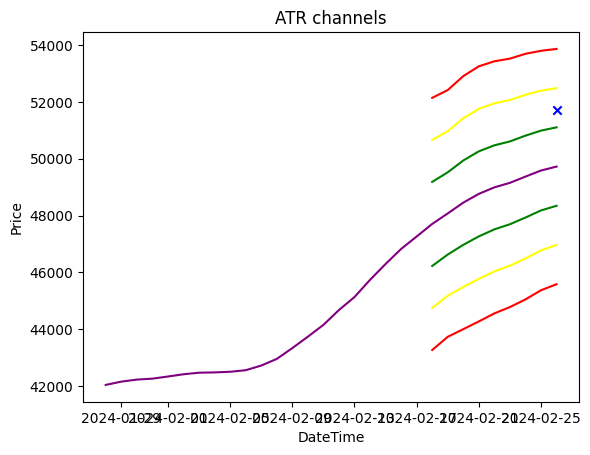

In [30]:
#Stop-i määramine
stop_price = 0

# Plotting multiple lines on the same chart
plt.plot(df_medium['dateTime'], df_medium['21EMA'], label='21EMA', color = 'purple')
plt.plot(df_medium['dateTime'], df_medium['ATR+1'], label='ATR+1',color = 'green')
plt.plot(df_medium['dateTime'], df_medium['ATR+2'], label='ATR+2',color = 'yellow')
plt.plot(df_medium['dateTime'], df_medium['ATR+3'], label='ATR+3',color = 'red')
plt.plot(df_medium['dateTime'], df_medium['ATR-1'], label='ATR-1',color = 'green')
plt.plot(df_medium['dateTime'], df_medium['ATR-2'], label='ATR-2',color = 'yellow')
plt.plot(df_medium['dateTime'], df_medium['ATR-3'], label='ATR-3',color = 'red')

# Show current price with an 'x'
last_price_x = df_medium['dateTime'].iloc[-1]
last_price_y = df_medium['Open Price'].iloc[-1]
plt.scatter(last_price_x, last_price_y, c='blue', marker='x', label='Last Price')

# Adding labels and title
plt.xlabel('DateTime')
plt.ylabel('Price')
plt.title('ATR channels')
plt.yticks()

plt.show()

## Nüüd edasi siis stop-i ja entry määramine, aga selleks vaja veel teooriat

# SCREENER

In [37]:




url = "https://api.binance.com/api/v3/ticker/24hr"
response = requests.get(url)
data = response.json()


In [38]:
data

[{'symbol': 'ETHBTC',
  'priceChange': '0.00097000',
  'priceChangePercent': '1.648',
  'weightedAvgPrice': '0.05983427',
  'prevClosePrice': '0.05886000',
  'lastPrice': '0.05983000',
  'lastQty': '0.30370000',
  'bidPrice': '0.05983000',
  'bidQty': '23.38540000',
  'askPrice': '0.05984000',
  'askQty': '19.70140000',
  'openPrice': '0.05886000',
  'highPrice': '0.06050000',
  'lowPrice': '0.05877000',
  'volume': '52623.31510000',
  'quoteVolume': '3148.67773163',
  'openTime': 1708865659165,
  'closeTime': 1708952059165,
  'firstId': 433490000,
  'lastId': 433601602,
  'count': 111603},
 {'symbol': 'LTCBTC',
  'priceChange': '0.00000600',
  'priceChangePercent': '0.442',
  'weightedAvgPrice': '0.00135913',
  'prevClosePrice': '0.00135600',
  'lastPrice': '0.00136200',
  'lastQty': '28.01600000',
  'bidPrice': '0.00136100',
  'bidQty': '260.06300000',
  'askPrice': '0.00136200',
  'askQty': '294.66800000',
  'openPrice': '0.00135600',
  'highPrice': '0.00136900',
  'lowPrice': '0.00

In [64]:
data = response.json()
symbol_count_dict = {entry.get('symbol', None): entry.get('count', None) for entry in data if 'USDT' in entry.get('symbol', '')}

sorted_dict_values = dict(sorted(symbol_count_dict.items(), key=lambda item: item[1], reverse = True))



top_crypto_usdt = list(sorted_dict_values.keys())[:30]
top_crypto_usdt


['ETHUSDT',
 'COTIUSDT',
 'BTCUSDT',
 'XVGUSDT',
 'FDUSDUSDT',
 'CKBUSDT',
 'WLDUSDT',
 'SPELLUSDT',
 'USTCUSDT',
 'SCUSDT',
 'JASMYUSDT',
 'ORNUSDT',
 'PIXELUSDT',
 'XAIUSDT',
 'SOLUSDT',
 'ACEUSDT',
 'MANTAUSDT',
 'BNBUSDT',
 'LUNCUSDT',
 'ARKMUSDT',
 'UNIUSDT',
 'AGIXUSDT',
 'NFPUSDT',
 'DARUSDT',
 'ALICEUSDT',
 'ALTUSDT',
 'FETUSDT',
 'PHBUSDT',
 'RNDRUSDT',
 'ORDIUSDT']

In [58]:
my_dict = {'banana': 3, 'apple': 1, 'orange': 2}

# Sort by values
sorted_dict_values = dict(sorted(my_dict.items(), key=lambda item: item[1]))

print("Sorted by values:", sorted_dict_values)

Sorted by values: {'apple': 1, 'orange': 2, 'banana': 3}


In [66]:
#Ticker list

def get_top_cryptos_with_usdt(number = 30):
    url = "https://api.binance.com/api/v3/ticker/24hr"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        symbol_count_dict = {entry.get('symbol', None): entry.get('count', None) for entry in data if 'USDT' in entry.get('symbol', '')}
        sorted_dict_values = dict(sorted(symbol_count_dict.items(), key=lambda item: item[1], reverse = True))
        top_crypto_usdt = list(sorted_dict_values.keys())[:number]
        return top_crypto_usdt
    else:
        print(f"Error: {response.status_code}")
        return None

# Run the function
top_cryptos_usdt = get_top_cryptos_with_usdt()

top_cryptos_usdt


['BTCUSDT',
 'ETHUSDT',
 'FDUSDUSDT',
 'SOLUSDT',
 'PEPEUSDT',
 'PYTHUSDT',
 'WLDUSDT',
 'THETAUSDT',
 'ALTUSDT',
 'MEMEUSDT',
 'COTIUSDT',
 'FLOKIUSDT',
 'DOGEUSDT',
 'STXUSDT',
 'ORDIUSDT',
 'XVGUSDT',
 'MANTAUSDT',
 'CKBUSDT',
 'XRPUSDT',
 'ILVUSDT',
 'BNBUSDT',
 'BONKUSDT',
 'SHIBUSDT',
 'DARUSDT',
 'SEIUSDT',
 'XAIUSDT',
 'GALAUSDT',
 'JASMYUSDT',
 'MATICUSDT',
 'ACEUSDT']

In [33]:
#Leian top krüptod
#Laen iga krüpto kopta alla pika vaate
#teen EMA ja MACD arvutused
#teen Elder Impulse arvutused
#Tahan näidata ainult teatud stocke. Ehk siis tahan näidata algselt ainult neid, kus peale punast tuleb roheline vüi sinine

In [34]:
df_long.tail(5)

,Time,Open Price,High Price,Low Price,Close Price,Volume,dateTime,13EMA,12EMA,26EMA,MACD,Signal,Histogram,elder_impulse
47,1706486400000,42031.05,43882.36,41804.88,42582.88,203036.61925,2024-01-29,40174.154188,40480.278326,36703.675933,3776.602393,3617.655321,158.947071,0.0
48,1707091200000,42582.88,48592.66,42258.10,48299.99,262240.48357,2024-02-05,41334.987875,41683.310891,37562.662160,4120.648731,3718.254003,402.394728,1.0
49,1707696000000,48300.00,52816.62,47710.01,52137.67,310862.30170,2024-02-12,42878.228179,43291.673831,38642.292371,4649.381460,3904.479495,744.901966,1.0
50,1708300800000,52137.68,52985.00,50521.00,51728.85,223366.16186,2024-02-19,44142.602725,44589.700934,39611.667010,4978.033924,4119.190380,858.843543,1.0
51,1708905600000,51728.85,51796.50,50901.44,51112.59,11110.00384,2024-02-26,45138.315192,45593.222329,40463.587231,5129.635097,4321.279324,808.355773,0.0


In [67]:
bull_set = set() #Creating a set for all bulls
bear_set = set() #Creating a set for all bears

for crypto in top_cryptos_usdt:
    df = get_historical_data(crypto, 360, '1w')
    df = transform_hist_data(df)
    df = calculate_emas(df)
    df = calculate_macd(df)
    df = calculate_elder(df)
    if df.iloc[-2]['elder_impulse'] == -1 and df.iloc[-1]['elder_impulse'] == 0 or df.iloc[-1]['elder_impulse'] == 1:
        bull_set.add(crypto)
        print("Added " + crypto + " to bull_set")
    elif df.iloc[-2]['elder_impulse'] == 1 and df.iloc[-1]['elder_impulse'] == 0 or df.iloc[-1]['elder_impulse'] == -1:
        bear_set.add(crypto)
        print("Added " + crypto + " to bear_set")
    else:
        print(crypto + " is not acceptable")
    time.sleep(1)
    
    
    

Retrived data for: BTCUSDT
Added BTCUSDT to bull_set
Retrived data for: ETHUSDT
Added ETHUSDT to bull_set
Retrived data for: FDUSDUSDT
Added FDUSDUSDT to bear_set
Retrived data for: SOLUSDT
SOLUSDT is not acceptable
Retrived data for: PEPEUSDT
Added PEPEUSDT to bull_set
Retrived data for: PYTHUSDT
Added PYTHUSDT to bull_set
Retrived data for: WLDUSDT
Added WLDUSDT to bull_set
Retrived data for: THETAUSDT
Added THETAUSDT to bull_set
Retrived data for: ALTUSDT
Added ALTUSDT to bull_set
Retrived data for: MEMEUSDT
Added MEMEUSDT to bull_set
Retrived data for: COTIUSDT
Added COTIUSDT to bull_set
Retrived data for: FLOKIUSDT
Added FLOKIUSDT to bull_set
Retrived data for: DOGEUSDT
Added DOGEUSDT to bull_set
Retrived data for: STXUSDT
Added STXUSDT to bull_set
Retrived data for: ORDIUSDT
ORDIUSDT is not acceptable
Retrived data for: XVGUSDT
Added XVGUSDT to bull_set
Retrived data for: MANTAUSDT
MANTAUSDT is not acceptable
Retrived data for: CKBUSDT
Added CKBUSDT to bull_set
Retrived data for:

In [69]:
bull_set

{'ACEUSDT',
 'ALTUSDT',
 'BNBUSDT',
 'BONKUSDT',
 'BTCUSDT',
 'CKBUSDT',
 'COTIUSDT',
 'DARUSDT',
 'DOGEUSDT',
 'ETHUSDT',
 'FLOKIUSDT',
 'GALAUSDT',
 'ILVUSDT',
 'JASMYUSDT',
 'MATICUSDT',
 'MEMEUSDT',
 'PEPEUSDT',
 'PYTHUSDT',
 'SHIBUSDT',
 'STXUSDT',
 'THETAUSDT',
 'WLDUSDT',
 'XAIUSDT',
 'XRPUSDT',
 'XVGUSDT'}

In [70]:
bear_set

{'FDUSDUSDT'}